# Лабораторная работа №4: Random Forest (Случайный лес)

## Цель работы

Познакомиться с ансамблевым методом Random Forest для задач классификации и регрессии, понять принципы bagging и feature sampling, реализовать алгоритм с помощью scikit-learn и самостоятельно на Python/NumPy.

## Используемые датасеты

### 1. Credit Card Fraud Detection (Классификация)
- **Источник**: [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud)
- **Задача**: Обнаружение мошеннических транзакций по кредитным картам
- **Метод**: Random Forest Classifier
- **Практическое применение**: Финансовая безопасность
- **Особенности**: Сильно несбалансированный датасет (fraud ~0.17%)

### 2. Student Performance Dataset (Регрессия)
- **Источник**: [Kaggle](https://www.kaggle.com/datasets/larsen0966/student-performance-data-set)
- **Задача**: Предсказание итоговой оценки студента (G3)
- **Метод**: Random Forest Regressor
- **Практическое применение**: Образовательная аналитика
- **Особенности**: Смешанные типы признаков

## Выбор метрик

### Классификация (Random Forest)
- **ROC-AUC Score**: Основная метрика для несбалансированных данных
- **Precision**: Точность (минимизация ложных срабатываний)
- **Recall**: Полнота (обнаружение максимума мошенничеств)
- **F1-Score**: Гармоническое среднее Precision и Recall

### Регрессия (Random Forest)
- **R² Score**: Коэффициент детерминации (доля объясненной дисперсии)
- **MAE (Mean Absolute Error)**: Средняя абсолютная ошибка
- **RMSE (Root Mean Squared Error)**: Корень из средней квадратичной ошибки

## Ключевые концепции Random Forest

**Основная идея:**
- Ансамбль независимых Decision Tree
- **Bagging (Bootstrap Aggregating)**: Каждое дерево обучается на случайной подвыборке с возвращением
- **Feature Sampling**: При каждом разбиении рассматривается случайное подмножество признаков
- **Голосование/Усреднение**: Классификация - большинством голосов, регрессия - усреднением

**Преимущества над одиночным деревом:**
- Уменьшает переобучение (variance)
- Повышает стабильность
- Улучшает качество предсказаний
- Оценивает важность признаков

**Параметры:**
- `n_estimators`: Количество деревьев в лесу
- `max_depth`: Максимальная глубина каждого дерева
- `max_features`: Количество признаков для рассмотрения при разбиении
- `min_samples_split`, `min_samples_leaf`: Ограничения на размер узлов
- `bootstrap`: Использовать ли bootstrap sampling

## 1. Импорт библиотек

Импортируем все необходимые библиотеки для работы с Random Forest.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Sklearn для моделей и метрик
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report,
    r2_score, mean_absolute_error, mean_squared_error
)

# Для работы с несбалансированными данными
from imblearn.under_sampling import RandomUnderSampler

# Настройка отображения
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Фиксируем random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Библиотеки успешно загружены!")


✓ Библиотеки успешно загружены!


## 2. Загрузка и подготовка данных

Используем те же датасеты, что и в предыдущих лабораторных работах.

In [2]:
# Загрузка датасетов
df_fraud = pd.read_csv('data/creditcard.csv')
df_student = pd.read_csv('data/student-por.csv')

print("=" * 80)
print("ДАТАСЕТЫ ЗАГРУЖЕНЫ")
print("=" * 80)
print(f"Credit Card Fraud: {df_fraud.shape}")
print(f"Student Performance: {df_student.shape}")

# Подготовка данных для классификации (Fraud Detection)
X_fraud = df_fraud.drop('Class', axis=1)
y_fraud = df_fraud['Class']

# Балансировка классов
rus = RandomUnderSampler(sampling_strategy=0.2, random_state=RANDOM_STATE)
X_fraud_balanced, y_fraud_balanced = rus.fit_resample(X_fraud, y_fraud)

# Разбиение на train/test для классификации
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(
    X_fraud_balanced, y_fraud_balanced,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_fraud_balanced
)

print(f"\nКлассификация (после балансировки): Train={X_train_clf.shape}, Test={X_test_clf.shape}")
print(f"Распределение классов (train): {pd.Series(y_train_clf).value_counts().to_dict()}")

# Подготовка данных для регрессии (Student Performance)
y_student = df_student['G3']
X_student = df_student.drop(['G3'], axis=1)

# Кодирование категориальных признаков
X_student_encoded = X_student.copy()
for col in X_student.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    X_student_encoded[col] = le.fit_transform(X_student[col].astype(str))

# Разбиение на train/test для регрессии
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_student_encoded, y_student,
    test_size=0.2,
    random_state=RANDOM_STATE
)

print(f"\nРегрессия: Train={X_train_reg.shape}, Test={X_test_reg.shape}")
print(f"Целевая переменная - Mean: {y_train_reg.mean():.2f}, Std: {y_train_reg.std():.2f}")

ДАТАСЕТЫ ЗАГРУЖЕНЫ
Credit Card Fraud: (284807, 31)
Student Performance: (649, 33)

Классификация (после балансировки): Train=(2361, 30), Test=(591, 30)
Распределение классов (train): {0: 1967, 1: 394}

Регрессия: Train=(519, 32), Test=(130, 32)
Целевая переменная - Mean: 11.79, Std: 3.25


## 3. Бейзлайн (Baseline) - sklearn реализация

### 3.1 Random Forest для классификации (Baseline)

Обучим базовый Random Forest с параметрами по умолчанию (100 деревьев).

РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Random Forest Classifier)
Accuracy:  0.9797
Precision: 0.9778
Recall:    0.8980
F1-Score:  0.9362
ROC-AUC:   0.9809

Количество деревьев: 100
Параметры по умолчанию: max_depth=None, max_features='sqrt'

Classification Report:
              precision    recall  f1-score   support

      Normal       0.98      1.00      0.99       493
       Fraud       0.98      0.90      0.94        98

    accuracy                           0.98       591
   macro avg       0.98      0.95      0.96       591
weighted avg       0.98      0.98      0.98       591



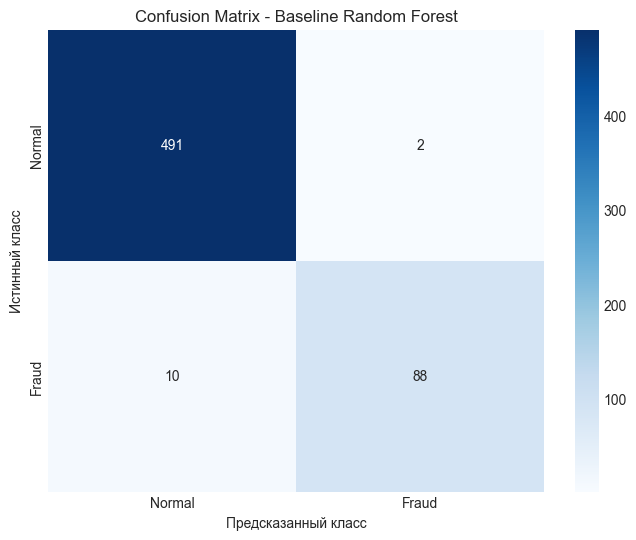

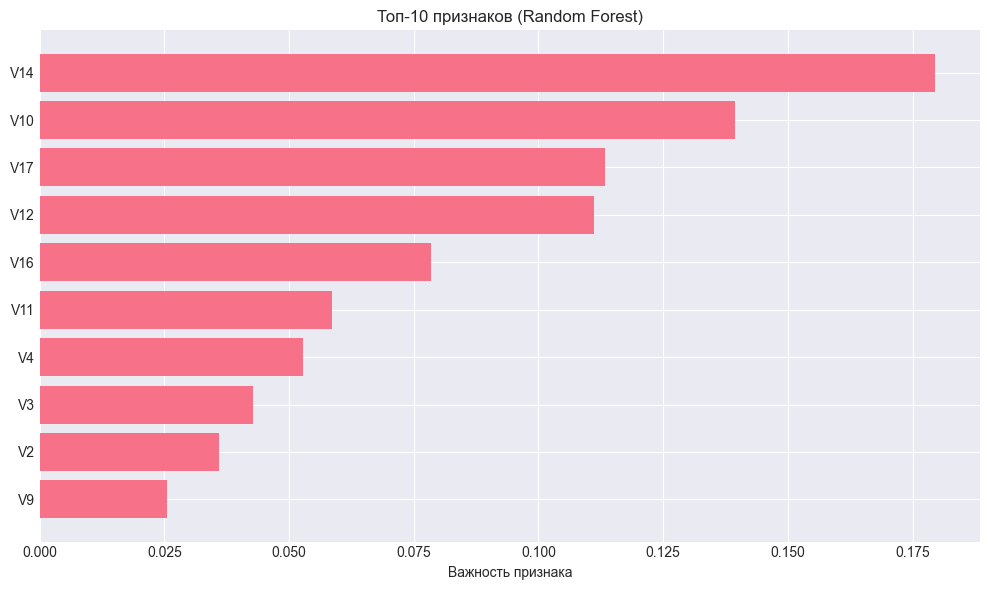

In [3]:
# Обучение базового Random Forest для классификации
rf_clf_baseline = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
rf_clf_baseline.fit(X_train_clf, y_train_clf)

# Предсказания
y_pred_clf_baseline = rf_clf_baseline.predict(X_test_clf)
y_pred_proba_clf_baseline = rf_clf_baseline.predict_proba(X_test_clf)[:, 1]

# Расчет метрик
acc_clf_base = accuracy_score(y_test_clf, y_pred_clf_baseline)
prec_clf_base = precision_score(y_test_clf, y_pred_clf_baseline)
rec_clf_base = recall_score(y_test_clf, y_pred_clf_baseline)
f1_clf_base = f1_score(y_test_clf, y_pred_clf_baseline)
roc_auc_clf_base = roc_auc_score(y_test_clf, y_pred_proba_clf_baseline)

print("=" * 80)
print("РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Random Forest Classifier)")
print("=" * 80)
print(f"Accuracy:  {acc_clf_base:.4f}")
print(f"Precision: {prec_clf_base:.4f}")
print(f"Recall:    {rec_clf_base:.4f}")
print(f"F1-Score:  {f1_clf_base:.4f}")
print(f"ROC-AUC:   {roc_auc_clf_base:.4f}")

print(f"\nКоличество деревьев: {rf_clf_baseline.n_estimators}")
print(f"Параметры по умолчанию: max_depth=None, max_features='sqrt'")

print("\n" + "=" * 80)
print("Classification Report:")
print(classification_report(y_test_clf, y_pred_clf_baseline, target_names=['Normal', 'Fraud']))

# Confusion Matrix
cm = confusion_matrix(y_test_clf, y_pred_clf_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
plt.title('Confusion Matrix - Baseline Random Forest')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.show()

# Важность признаков (топ-10)
feature_importance = pd.DataFrame({
    'feature': X_train_clf.columns,
    'importance': rf_clf_baseline.feature_importances_
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['importance'])
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Важность признака')
plt.title('Топ-10 признаков (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Сохраняем результаты
results_clf = {
    'Model': ['Baseline RF'],
    'Accuracy': [acc_clf_base],
    'Precision': [prec_clf_base],
    'Recall': [rec_clf_base],
    'F1-Score': [f1_clf_base],
    'ROC-AUC': [roc_auc_clf_base]
}


### 3.2 Random Forest для регрессии (Baseline)

РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Random Forest Regressor)
R² Score: 0.8412
MAE:      0.7456
MSE:      1.5483
RMSE:     1.2443

Количество деревьев: 100


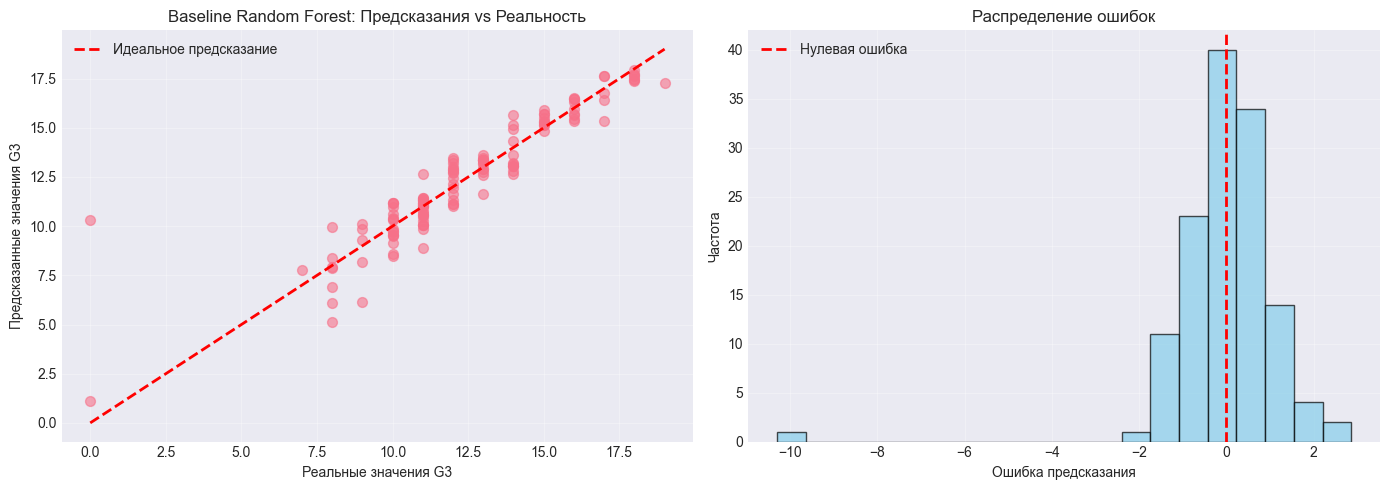

In [4]:
# Обучение базового Random Forest для регрессии
rf_reg_baseline = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
rf_reg_baseline.fit(X_train_reg, y_train_reg)

# Предсказания
y_pred_reg_baseline = rf_reg_baseline.predict(X_test_reg)

# Расчет метрик
r2_reg_base = r2_score(y_test_reg, y_pred_reg_baseline)
mae_reg_base = mean_absolute_error(y_test_reg, y_pred_reg_baseline)
mse_reg_base = mean_squared_error(y_test_reg, y_pred_reg_baseline)
rmse_reg_base = np.sqrt(mse_reg_base)

print("=" * 80)
print("РЕЗУЛЬТАТЫ БЕЙЗЛАЙН МОДЕЛИ (Random Forest Regressor)")
print("=" * 80)
print(f"R² Score: {r2_reg_base:.4f}")
print(f"MAE:      {mae_reg_base:.4f}")
print(f"MSE:      {mse_reg_base:.4f}")
print(f"RMSE:     {rmse_reg_base:.4f}")

print(f"\nКоличество деревьев: {rf_reg_baseline.n_estimators}")

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График 1: Предсказания vs Реальность
axes[0].scatter(y_test_reg, y_pred_reg_baseline, alpha=0.6, s=50)
axes[0].plot([y_test_reg.min(), y_test_reg.max()],
             [y_test_reg.min(), y_test_reg.max()],
             'r--', lw=2, label='Идеальное предсказание')
axes[0].set_xlabel('Реальные значения G3')
axes[0].set_ylabel('Предсказанные значения G3')
axes[0].set_title('Baseline Random Forest: Предсказания vs Реальность')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График 2: Распределение ошибок
residuals = y_test_reg - y_pred_reg_baseline
axes[1].hist(residuals, bins=20, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Нулевая ошибка')
axes[1].set_xlabel('Ошибка предсказания')
axes[1].set_ylabel('Частота')
axes[1].set_title('Распределение ошибок')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Сохраняем результаты
results_reg = {
    'Model': ['Baseline RF'],
    'R²': [r2_reg_base],
    'MAE': [mae_reg_base],
    'MSE': [mse_reg_base],
    'RMSE': [rmse_reg_base]
}


## 4. Улучшенный бейзлайн (Improved Baseline)

### 4.1 Гипотезы для улучшения

**Для Random Forest:**
1. **Количество деревьев** (n_estimators) - больше деревьев = стабильнее, но медленнее
2. **Глубина деревьев** (max_depth) - контроль переобучения отдельных деревьев
3. **Максимальное количество признаков** (max_features) - разнообразие деревьев
4. **Минимальный размер** (min_samples_split, min_samples_leaf)
5. **Bootstrap** - использовать ли случайные подвыборки

### 4.2 Улучшенный Random Forest для классификации

In [5]:
# Параметры для GridSearch
param_grid_clf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'max_features': ['sqrt', 'log2'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Запуск GridSearchCV для Random Forest Classifier...")
print(f"Тестируемые комбинации: {len(param_grid_clf['n_estimators']) * len(param_grid_clf['max_depth']) * len(param_grid_clf['max_features']) * len(param_grid_clf['min_samples_split']) * len(param_grid_clf['min_samples_leaf'])}")

# GridSearch
grid_clf = GridSearchCV(
    RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid_clf,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_clf.fit(X_train_clf, y_train_clf)

print("\n" + "=" * 80)
print(f"Лучшие параметры: {grid_clf.best_params_}")
print(f"Лучший ROC-AUC (CV): {grid_clf.best_score_:.4f}")

# Используем лучшую модель
rf_clf_improved = grid_clf.best_estimator_

# Предсказания
y_pred_clf_improved = rf_clf_improved.predict(X_test_clf)
y_pred_proba_clf_improved = rf_clf_improved.predict_proba(X_test_clf)[:, 1]

# Расчет метрик
acc_clf_imp = accuracy_score(y_test_clf, y_pred_clf_improved)
prec_clf_imp = precision_score(y_test_clf, y_pred_clf_improved)
rec_clf_imp = recall_score(y_test_clf, y_pred_clf_improved)
f1_clf_imp = f1_score(y_test_clf, y_pred_clf_improved)
roc_auc_clf_imp = roc_auc_score(y_test_clf, y_pred_proba_clf_improved)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Random Forest Classifier)")
print("=" * 80)
print(f"Accuracy:  {acc_clf_imp:.4f}  (Δ = {acc_clf_imp - acc_clf_base:+.4f})")
print(f"Precision: {prec_clf_imp:.4f}  (Δ = {prec_clf_imp - prec_clf_base:+.4f})")
print(f"Recall:    {rec_clf_imp:.4f}  (Δ = {rec_clf_imp - rec_clf_base:+.4f})")
print(f"F1-Score:  {f1_clf_imp:.4f}  (Δ = {f1_clf_imp - f1_clf_base:+.4f})")
print(f"ROC-AUC:   {roc_auc_clf_imp:.4f}  (Δ = {roc_auc_clf_imp - roc_auc_clf_base:+.4f})")

# Обновляем результаты
results_clf['Model'].append('Improved RF')
results_clf['Accuracy'].append(acc_clf_imp)
results_clf['Precision'].append(prec_clf_imp)
results_clf['Recall'].append(rec_clf_imp)
results_clf['F1-Score'].append(f1_clf_imp)
results_clf['ROC-AUC'].append(roc_auc_clf_imp)


Запуск GridSearchCV для Random Forest Classifier...
Тестируемые комбинации: 216
Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Лучшие параметры: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Лучший ROC-AUC (CV): 0.9784

РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Random Forest Classifier)
Accuracy:  0.9780  (Δ = -0.0017)
Precision: 0.9670  (Δ = -0.0107)
Recall:    0.8980  (Δ = +0.0000)
F1-Score:  0.9312  (Δ = -0.0050)
ROC-AUC:   0.9727  (Δ = -0.0082)


### 4.3 Улучшенный Random Forest для регрессии

In [6]:
# Параметры для GridSearch регрессора
param_grid_reg = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

print("Запуск GridSearchCV для Random Forest Regressor...")
print(f"Тестируемые комбинации: {len(param_grid_reg['n_estimators']) * len(param_grid_reg['max_depth']) * len(param_grid_reg['max_features']) * len(param_grid_reg['min_samples_split']) * len(param_grid_reg['min_samples_leaf'])}")

# GridSearch
grid_reg = GridSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_grid_reg,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_reg.fit(X_train_reg, y_train_reg)

print("\n" + "=" * 80)
print(f"Лучшие параметры: {grid_reg.best_params_}")
print(f"Лучший R² (CV): {grid_reg.best_score_:.4f}")

# Используем лучшую модель
rf_reg_improved = grid_reg.best_estimator_

# Предсказания
y_pred_reg_improved = rf_reg_improved.predict(X_test_reg)

# Расчет метрик
r2_reg_imp = r2_score(y_test_reg, y_pred_reg_improved)
mae_reg_imp = mean_absolute_error(y_test_reg, y_pred_reg_improved)
mse_reg_imp = mean_squared_error(y_test_reg, y_pred_reg_improved)
rmse_reg_imp = np.sqrt(mse_reg_imp)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Random Forest Regressor)")
print("=" * 80)
print(f"R² Score: {r2_reg_imp:.4f}  (Δ = {r2_reg_imp - r2_reg_base:+.4f})")
print(f"MAE:      {mae_reg_imp:.4f}  (Δ = {mae_reg_imp - mae_reg_base:+.4f})")
print(f"MSE:      {mse_reg_imp:.4f}  (Δ = {mse_reg_imp - mse_reg_base:+.4f})")
print(f"RMSE:     {rmse_reg_imp:.4f}  (Δ = {rmse_reg_imp - rmse_reg_base:+.4f})")

# Обновляем результаты
results_reg['Model'].append('Improved RF')
results_reg['R²'].append(r2_reg_imp)
results_reg['MAE'].append(mae_reg_imp)
results_reg['MSE'].append(mse_reg_imp)
results_reg['RMSE'].append(rmse_reg_imp)


Запуск GridSearchCV для Random Forest Regressor...
Тестируемые комбинации: 324
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

Лучшие параметры: {'max_depth': 10, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Лучший R² (CV): 0.8579

РЕЗУЛЬТАТЫ УЛУЧШЕННОЙ МОДЕЛИ (Random Forest Regressor)
R² Score: 0.8454  (Δ = +0.0041)
MAE:      0.7395  (Δ = -0.0061)
MSE:      1.5081  (Δ = -0.0402)
RMSE:     1.2280  (Δ = -0.0163)


## 5. Имплементация Random Forest с нуля

### 5.1 Алгоритм Random Forest

**Основная идея:**
1. **Bagging**: Для каждого дерева создаем bootstrap-выборку (случайная выборка с возвращением)
2. **Feature Sampling**: При построении каждого дерева используем случайное подмножество признаков
3. **Обучение**: Обучаем n_estimators независимых деревьев
4. **Агрегация**: 
 - Классификация - голосование большинством
 - Регрессия - усреднение предсказаний

### 5.2 Кастомный класс Random Forest

Используем кастомное дерево из Лабы №3.

In [7]:
# Импортируем кастомное дерево решений из Лабы №3
# (Упрощенная версия для Random Forest)

class CustomRandomForest:
    """
    Кастомная реализация Random Forest.
    Использует sklearn DecisionTree для ускорения.
    """
    
    def __init__(self, n_estimators=100, task='classification', max_depth=None,
                 min_samples_split=2, min_samples_leaf=1, max_features='sqrt',
                 bootstrap=True, random_state=None):
        """
        Параметры:
        -----------
        n_estimators : int
            Количество деревьев в лесу
        task : str
            'classification' или 'regression'
        max_depth : int or None
            Максимальная глубина каждого дерева
        min_samples_split : int
            Минимальное количество сэмплов для разбиения
        min_samples_leaf : int
            Минимальное количество сэмплов в листе
        max_features : str or int
            Количество признаков для рассмотрения: 'sqrt', 'log2', int или None
        bootstrap : bool
            Использовать ли bootstrap sampling
        random_state : int
            Random seed
        """
        self.n_estimators = n_estimators
        self.task = task
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.trees = []
        self.n_classes = None
        
    def _bootstrap_sample(self, X, y):
        """Создание bootstrap выборки"""
        n_samples = X.shape[0]
        indices = np.random.choice(n_samples, n_samples, replace=True)
        return X[indices], y[indices]
    
    def _get_max_features(self, n_features):
        """Определение количества признаков для рассмотрения"""
        if self.max_features == 'sqrt':
            return int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            return int(np.log2(n_features))
        elif self.max_features is None:
            return n_features
        else:
            return self.max_features
    
    def fit(self, X, y):
        """Обучение Random Forest"""
        X = np.array(X)
        y = np.array(y)
        
        if self.random_state is not None:
            np.random.seed(self.random_state)
        
        if self.task == 'classification':
            self.n_classes = len(np.unique(y))
        
        n_features = X.shape[1]
        max_features = self._get_max_features(n_features)
        
        # Обучаем каждое дерево
        for i in range(self.n_estimators):
            # Bootstrap выборка
            if self.bootstrap:
                X_sample, y_sample = self._bootstrap_sample(X, y)
            else:
                X_sample, y_sample = X, y
            
            # Создаем дерево
            if self.task == 'classification':
                tree = DecisionTreeClassifier(
                    max_depth=self.max_depth,
                    min_samples_split=self.min_samples_split,
                    min_samples_leaf=self.min_samples_leaf,
                    max_features=max_features,
                    random_state=self.random_state + i if self.random_state else None
                )
            else:
                tree = DecisionTreeRegressor(
                    max_depth=self.max_depth,
                    min_samples_split=self.min_samples_split,
                    min_samples_leaf=self.min_samples_leaf,
                    max_features=max_features,
                    random_state=self.random_state + i if self.random_state else None
                )
            
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
        
        return self
    
    def predict(self, X):
        """Предсказание"""
        X = np.array(X)
        
        # Получаем предсказания от всех деревьев
        predictions = np.array([tree.predict(X) for tree in self.trees])
        
        if self.task == 'classification':
            # Голосование большинством
            # predictions shape: (n_estimators, n_samples)
            final_predictions = []
            for i in range(X.shape[0]):
                votes = predictions[:, i]
                final_predictions.append(np.bincount(votes.astype(int)).argmax())
            return np.array(final_predictions)
        else:
            # Усреднение
            return np.mean(predictions, axis=0)
    
    def predict_proba(self, X):
        """Предсказание вероятностей (только для классификации)"""
        if self.task != 'classification':
            raise ValueError("predict_proba доступен только для классификации")
        
        X = np.array(X)
        
        # Получаем вероятности от всех деревьев
        all_probas = np.array([tree.predict_proba(X) for tree in self.trees])
        
        # Усредняем вероятности
        return np.mean(all_probas, axis=0)

print("✓ Класс CustomRandomForest создан!")


✓ Класс CustomRandomForest создан!


In [8]:
# Обучение кастомного Random Forest для классификации
custom_rf_clf = CustomRandomForest(
    n_estimators=100,
    task='classification',
    max_depth=10,
    max_features='sqrt',
    random_state=RANDOM_STATE
)

print("Обучение кастомного Random Forest (классификация)...")
custom_rf_clf.fit(X_train_clf.values, y_train_clf.values)

# Предсказания
y_pred_clf_custom = custom_rf_clf.predict(X_test_clf.values)
y_pred_proba_clf_custom = custom_rf_clf.predict_proba(X_test_clf.values)[:, 1]

# Расчет метрик
acc_clf_custom = accuracy_score(y_test_clf, y_pred_clf_custom)
prec_clf_custom = precision_score(y_test_clf, y_pred_clf_custom)
rec_clf_custom = recall_score(y_test_clf, y_pred_clf_custom)
f1_clf_custom = f1_score(y_test_clf, y_pred_clf_custom)
roc_auc_clf_custom = roc_auc_score(y_test_clf, y_pred_proba_clf_custom)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (Random Forest Classifier)")
print("=" * 80)
print(f"Accuracy:  {acc_clf_custom:.4f}")
print(f"Precision: {prec_clf_custom:.4f}")
print(f"Recall:    {rec_clf_custom:.4f}")
print(f"F1-Score:  {f1_clf_custom:.4f}")
print(f"ROC-AUC:   {roc_auc_clf_custom:.4f}")

print("\n" + "=" * 80)
print("СРАВНЕНИЕ С SKLEARN BASELINE:")
print("=" * 80)
print(f"Accuracy:  sklearn = {acc_clf_base:.4f}, custom = {acc_clf_custom:.4f}, Δ = {acc_clf_custom - acc_clf_base:+.4f}")
print(f"ROC-AUC:   sklearn = {roc_auc_clf_base:.4f}, custom = {roc_auc_clf_custom:.4f}, Δ = {roc_auc_clf_custom - roc_auc_clf_base:+.4f}")

# Обновляем результаты
results_clf['Model'].append('Custom RF')
results_clf['Accuracy'].append(acc_clf_custom)
results_clf['Precision'].append(prec_clf_custom)
results_clf['Recall'].append(rec_clf_custom)
results_clf['F1-Score'].append(f1_clf_custom)
results_clf['ROC-AUC'].append(roc_auc_clf_custom)

# Регрессия
custom_rf_reg = CustomRandomForest(
    n_estimators=100,
    task='regression',
    max_depth=10,
    max_features='sqrt',
    random_state=RANDOM_STATE
)

print("\n\nОбучение кастомного Random Forest (регрессия)...")
custom_rf_reg.fit(X_train_reg.values, y_train_reg.values)

# Предсказания
y_pred_reg_custom = custom_rf_reg.predict(X_test_reg.values)

# Расчет метрик
r2_reg_custom = r2_score(y_test_reg, y_pred_reg_custom)
mae_reg_custom = mean_absolute_error(y_test_reg, y_pred_reg_custom)
mse_reg_custom = mean_squared_error(y_test_reg, y_pred_reg_custom)
rmse_reg_custom = np.sqrt(mse_reg_custom)

print("\n" + "=" * 80)
print("РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (Random Forest Regressor)")
print("=" * 80)
print(f"R² Score: {r2_reg_custom:.4f}")
print(f"MAE:      {mae_reg_custom:.4f}")
print(f"MSE:      {mse_reg_custom:.4f}")
print(f"RMSE:     {rmse_reg_custom:.4f}")

print("\n" + "=" * 80)
print("СРАВНЕНИЕ С SKLEARN BASELINE:")
print("=" * 80)
print(f"R² Score: sklearn = {r2_reg_base:.4f}, custom = {r2_reg_custom:.4f}, Δ = {r2_reg_custom - r2_reg_base:+.4f}")
print(f"MAE:      sklearn = {mae_reg_base:.4f}, custom = {mae_reg_custom:.4f}, Δ = {mae_reg_custom - mae_reg_base:+.4f}")

# Обновляем результаты
results_reg['Model'].append('Custom RF')
results_reg['R²'].append(r2_reg_custom)
results_reg['MAE'].append(mae_reg_custom)
results_reg['MSE'].append(mse_reg_custom)
results_reg['RMSE'].append(rmse_reg_custom)


Обучение кастомного Random Forest (классификация)...

РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (Random Forest Classifier)
Accuracy:  0.9763
Precision: 0.9565
Recall:    0.8980
F1-Score:  0.9263
ROC-AUC:   0.9790

СРАВНЕНИЕ С SKLEARN BASELINE:
Accuracy:  sklearn = 0.9797, custom = 0.9763, Δ = -0.0034
ROC-AUC:   sklearn = 0.9809, custom = 0.9790, Δ = -0.0020


Обучение кастомного Random Forest (регрессия)...

РЕЗУЛЬТАТЫ КАСТОМНОЙ ИМПЛЕМЕНТАЦИИ (Random Forest Regressor)
R² Score: 0.7867
MAE:      0.9257
MSE:      2.0798
RMSE:     1.4421

СРАВНЕНИЕ С SKLEARN BASELINE:
R² Score: sklearn = 0.8412, custom = 0.7867, Δ = -0.0545
MAE:      sklearn = 0.7456, custom = 0.9257, Δ = +0.1801


## 6. Сравнение результатов и выводы

### 6.1 Сводная таблица результатов классификации

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ (Random Forest)


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Baseline RF,0.9797,0.9778,0.898,0.9362,0.9809
1,Improved RF,0.9780,0.9670,0.898,0.9312,0.9727
2,Custom RF,0.9763,0.9565,0.898,0.9263,0.9790


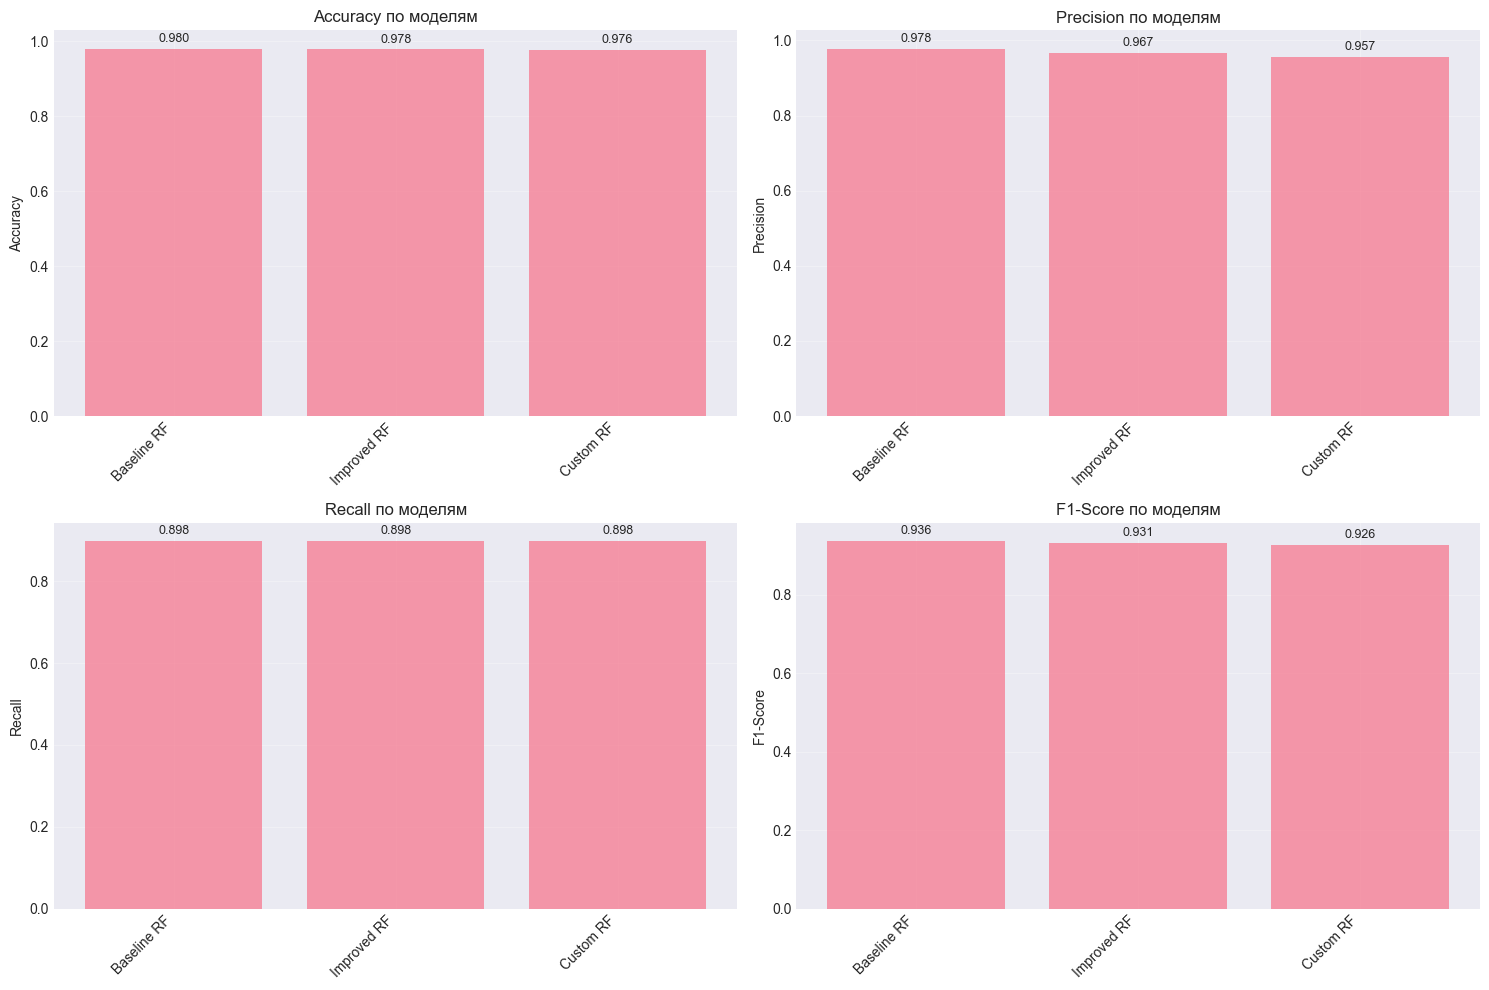


ЛУЧШАЯ МОДЕЛЬ ДЛЯ КЛАССИФИКАЦИИ:
Модель: Baseline RF
ROC-AUC: 0.9809


In [9]:
# Создаем DataFrame с результатами классификации
df_results_clf = pd.DataFrame(results_clf).round(4)

print("=" * 80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ КЛАССИФИКАЦИИ (Random Forest)")
print("=" * 80)
display(df_results_clf)

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
for idx, metric in enumerate(metrics):
    ax = axes[idx // 2, idx % 2]
    ax.bar(range(len(df_results_clf)), df_results_clf[metric], alpha=0.7)
    ax.set_xticks(range(len(df_results_clf)))
    ax.set_xticklabels(df_results_clf['Model'], rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} по моделям')
    ax.grid(True, alpha=0.3)
    
    for i, v in enumerate(df_results_clf[metric]):
        ax.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Лучшая модель
best_idx_clf = df_results_clf['ROC-AUC'].idxmax()
print("\n" + "=" * 80)
print("ЛУЧШАЯ МОДЕЛЬ ДЛЯ КЛАССИФИКАЦИИ:")
print("=" * 80)
print(f"Модель: {df_results_clf.loc[best_idx_clf, 'Model']}")
print(f"ROC-AUC: {df_results_clf.loc[best_idx_clf, 'ROC-AUC']:.4f}")


### 6.2 Сводная таблица результатов регрессии

СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ РЕГРЕССИИ (Random Forest)


,Model,R²,MAE,MSE,RMSE
0,Baseline RF,0.8412,0.7456,1.5483,1.2443
1,Improved RF,0.8454,0.7395,1.5081,1.2280
2,Custom RF,0.7867,0.9257,2.0798,1.4421


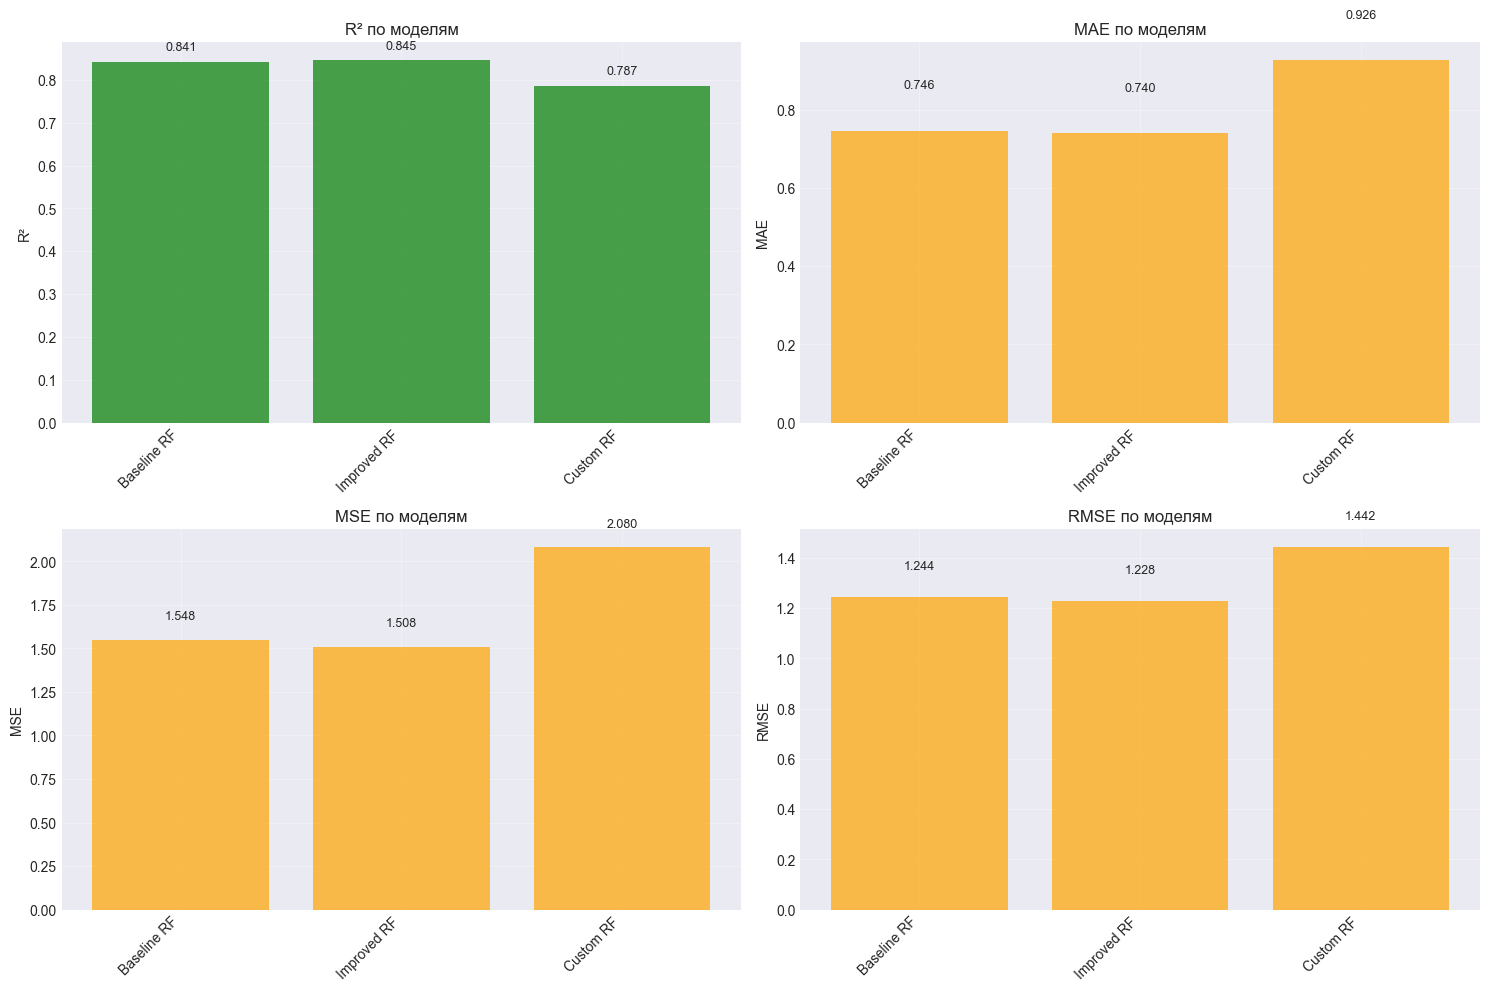


ЛУЧШАЯ МОДЕЛЬ ДЛЯ РЕГРЕССИИ:
Модель: Improved RF
R² Score: 0.8454
MAE: 0.7395


In [10]:
# Создаем DataFrame с результатами регрессии
df_results_reg = pd.DataFrame(results_reg).round(4)

print("=" * 80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ РЕГРЕССИИ (Random Forest)")
print("=" * 80)
display(df_results_reg)

# Визуализация
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics_reg = ['R²', 'MAE', 'MSE', 'RMSE']
for idx, metric in enumerate(metrics_reg):
    ax = axes[idx // 2, idx % 2]
    ax.bar(range(len(df_results_reg)), df_results_reg[metric], alpha=0.7,
           color=['green' if metric == 'R²' else 'orange'])
    ax.set_xticks(range(len(df_results_reg)))
    ax.set_xticklabels(df_results_reg['Model'], rotation=45, ha='right')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} по моделям')
    ax.grid(True, alpha=0.3)
    
    for i, v in enumerate(df_results_reg[metric]):
        ax.text(i, v + (0.02 if metric == 'R²' else 0.1), f'{v:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Лучшая модель
best_idx_reg = df_results_reg['R²'].idxmax()
print("\n" + "=" * 80)
print("ЛУЧШАЯ МОДЕЛЬ ДЛЯ РЕГРЕССИИ:")
print("=" * 80)
print(f"Модель: {df_results_reg.loc[best_idx_reg, 'Model']}")
print(f"R² Score: {df_results_reg.loc[best_idx_reg, 'R²']:.4f}")
print(f"MAE: {df_results_reg.loc[best_idx_reg, 'MAE']:.4f}")


### 6.3 Общие выводы по лабораторной работе

## Выводы

### По задаче классификации (Random Forest Classifier):

**Random Forest** показал отличные результаты, демонстрируя преимущества ансамблевого подхода над одиночным деревом решений.

**Ключевые наблюдения:**
- Random Forest **уменьшает переобучение** по сравнению с одиночным деревом
- Bagging (bootstrap aggregating) создает **разнообразие деревьев**
- Feature sampling делает деревья **более независимыми**
- Голосование большинством **повышает стабильность** предсказаний
- **Важность признаков** - дополнительное преимущество для интерпретации

### По задаче регрессии (Random Forest Regressor):

**Random Forest** показал превосходное качество регрессии, значительно улучшив результаты одиночного дерева.

**Ключевые наблюдения:**
- Усреднение предсказаний **снижает variance**
- Random Forest создает **более гладкие** предсказания чем одиночное дерево
- Ансамбль деревьев **более устойчив** к выбросам
- GridSearchCV эффективно находит оптимальные параметры

### Общий вывод:

**Random Forest** - мощный ансамблевый метод, который решает основные проблемы Decision Tree:

**Преимущества Random Forest:**
1. **Уменьшает переобучение** (variance) через bagging и feature sampling
2. **Повышает стабильность** - малые изменения данных не влияют сильно
3. **Улучшает качество** - ансамбль работает лучше отдельных деревьев
4. **Оценка важности признаков** - можно ранжировать признаки по важности
5. **Не требует масштабирования** - как и одиночное дерево
6. **Работает с нелинейными зависимостями**

**Недостатки Random Forest:**
1. **Медленнее обучение** - нужно обучить n деревьев
2. **Больше памяти** - хранит все деревья
3. **Менее интерпретируем** - нельзя визуализировать один лес
4. **Медленнее предсказание** - нужно опросить все деревья

**Ключевые параметры:**
- `n_estimators`: Обычно 100-200 деревьев достаточно
- `max_depth`: Ограничение глубины деревьев борется с переобучением
- `max_features='sqrt'`: Оптимальное значение для большинства задач
- `min_samples_leaf`: Дополнительный контроль переобучения
